In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
import copy
import os
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets
import matplotlib.pyplot as plt
import cv2
from datetime import datetime
from torch.optim import lr_scheduler
import albumentations
from PIL import Image
from PIL import ImageFile

In [2]:
class ClassificationDataset:
    def __init__(self, image_paths, targets, resize=None):
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        
        # ImageNet mean and std
        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)
        self.aug = albumentations.Compose(
            [
                albumentations.Normalize(
                    mean, std, max_pixel_value=255.0, always_apply=True)
            ]
        )

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, item):
        image = Image.open(self.image_paths[item]).convert("RGB")
        targets = self.targets[item]
        accelerate_target = targets[2]
        steering_target = targets[0]
        if self.resize is not None:
            image = image.resize(
                resize, resample=Image.BILINEAR
            )

        image = np.array(image)
        augmented = self.aug(image=image)
        image = augmented["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        return {
            "images": torch.tensor(image, dtype=torch.float),
            "accelerate_targets": torch.tensor(accelerate_target, dtype=torch.float),
            "steering_targets": torch.tensor(steering_target, dtype=torch.float)
        }

In [3]:
import glob
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
batch_size = 128
resize = (200,66)
DATA_DIR = "/home/gabriel/Área de Trabalho/mk8_dataset-roi"
image_files = glob.glob(os.path.join(DATA_DIR, "*.png"))
targets_orig = [eval(x.split("/")[-1][:-4].split("-hash_")[0]) for x in image_files] #list of lists containing the relevant list in the filename for each image

train_images,test_images,train_targets,test_targets = model_selection.train_test_split(
    image_files, targets_orig, test_size=0.1, random_state=42)

train_dataset = ClassificationDataset(
    image_paths=train_images,
    targets=train_targets,
    resize=resize
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=1,
    shuffle=True,
)

test_dataset = ClassificationDataset(
    image_paths=test_images,
    targets=test_targets,
    resize=resize,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=1,
    shuffle=False,
)

dataloaders = {
    "train": train_loader,
    "val": test_loader 
}

In [4]:
train_dataset.__getitem__(1)

{'images': tensor([[[-0.5082, -0.0801,  0.4679,  ..., -0.0972, -0.2856, -0.1657],
          [-0.4568, -0.6281, -0.2513,  ..., -0.0801, -0.2856, -0.1657],
          [-0.4226, -0.6965, -0.5082,  ..., -0.0801, -0.3027, -0.1828],
          ...,
          [-0.1486, -0.1657, -0.1657,  ..., -0.0801, -0.1143, -0.2513],
          [-0.1486, -0.1657, -0.1828,  ..., -0.1486, -0.1143, -0.2342],
          [-0.1657, -0.1314, -0.1657,  ..., -0.1486, -0.0972, -0.1999]],
 
         [[ 0.3277,  1.7983,  2.2710,  ..., -0.3375, -0.5126, -0.7927],
          [ 0.3277,  1.2906,  1.6758,  ..., -0.3375, -0.5126, -0.7752],
          [ 0.3978,  1.1506,  1.3957,  ..., -0.3200, -0.5126, -0.7752],
          ...,
          [-0.1450, -0.1625, -0.1450,  ..., -0.0399, -0.0749, -0.2150],
          [-0.1275, -0.1450, -0.1625,  ..., -0.0924, -0.0574, -0.2150],
          [-0.1450, -0.1275, -0.1450,  ..., -0.1099, -0.0224, -0.1800]],
 
         [[ 0.1476,  1.6988,  2.4831,  ..., -1.1596, -1.2293, -1.3339],
          [ 0.0605

# Autonomous Steering model and training

In [5]:
class SteeringModel(nn.Module):
    #reference: https://arxiv.org/abs/1604.07316
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=24, kernel_size=(5,5),stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=24, out_channels=36, kernel_size=(5,5),stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=36, out_channels=48, kernel_size=(5,5),stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=(3,3),stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3),stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152,100),
            nn.Linear(100,50),
            nn.Linear(50,10),
            nn.Linear(10,1)
        )
    def forward(self,inputs):
        x = self.backbone(inputs)
        return x

In [6]:
lr=0.001
model = SteeringModel()
device = torch.device('cuda')
optimizer = optim.Adam(model.parameters(), lr=lr)
#scheduler = lr_scheduler.StepLR(optimizer,step_size=7, gamma=0.1)
criterion = nn.MSELoss()

In [7]:
from tqdm.notebook import tqdm
num_epoches = 40
train_losses = []
val_losses = []
lowest_loss = 500.0
best_model_wts = copy.deepcopy(model.state_dict())
since = time.time()
for epoch in range(num_epoches):
    print('Epoch {}/{}'.format(epoch, num_epoches - 1))
    print('-' * 10)
    running_loss = 0.0
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
        else:
            model.eval()
            
        for inputs in tqdm(dataloaders[phase]):
            # unpack data in train_loader
            batch_images = inputs["images"]
            #acc_targets = inputs["accelerate_targets"]
            steer_targets = inputs["steering_targets"]

            # adds dimensions to convert into single row tensor
            #acc_targets =  torch.unsqueeze(acc_targets, 1)
            steer_targets =  torch.unsqueeze(steer_targets, 1)

            # insert data in cpu or gpu
            batch_images.to(device)
            #acc_targets.to(device)
            steer_targets.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                #print(phase == 'train')
                steer_out = model(batch_images)
                #acc_loss = accelerate_loss(acc_out,acc_targets)
                #steer_loss = steering_loss(steer_out,steer_targets)
                loss = criterion(steer_out,steer_targets)

            if phase== "train":
                loss.backward()
                optimizer.step()

            running_loss += loss.item() # batch_size
            
        epoch_loss = running_loss / len(dataloaders[phase]) * batch_size
        
        if phase == "train":
            train_losses.append(epoch_loss)
            #scheduler.step()
        else:
            if epoch_loss < lowest_loss:
                lowest_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                PATH = f'./mk8-model-2-checkpoints/mk8-model-roi-checkpoint-epoche-{epoch}.pth'
                torch.save(model.state_dict(), PATH)
            val_losses.append(epoch_loss)

        print(f"{datetime.now().time().replace(microsecond=0)} - Loss for {phase}: {epoch_loss}")
        
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
PATH = './mk8-steering-model-2.pth'
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), PATH)

Epoch 0/39
----------



16:09:47 - Loss for train: 24.845387635407626



16:10:27 - Loss for val: 236.51101700464883
Epoch 1/39
----------



16:15:25 - Loss for train: 9.17905705946463



16:16:03 - Loss for val: 90.26318840185802
Epoch 2/39
----------



16:20:49 - Loss for train: 6.743253628412883



16:21:27 - Loss for val: 67.4373249610265
Epoch 3/39
----------



16:25:48 - Loss for train: 5.949747880299886



16:26:06 - Loss for val: 60.07710123062134
Epoch 4/39
----------



16:30:13 - Loss for train: 5.312885904753649



16:30:49 - Loss for val: 53.25645172595978
Epoch 5/39
----------



16:35:08 - Loss for train: 4.635188195440504



16:35:28 - Loss for val: 46.89030762513479
Epoch 6/39
----------



16:39:42 - Loss for train: 4.2477123759410995



16:40:04 - Loss for val: 43.589856684207916
Epoch 7/39
----------



16:44:19 - Loss for train: 3.8688662118381925



16:44:42 - Loss for val: 39.8983408610026
Epoch 8/39
----------



16:48:44 - Loss for train: 3.707973994590618



16:49:17 - Loss for val: 38.00383494297663
Epoch 9/39
----------



16:53:16 - Loss for train: 3.30987278620402



16:53:37 - Loss for val: 34.13403743505478
Epoch 10/39
----------



16:57:29 - Loss for train: 3.1001623272895813



16:57:47 - Loss for val: 32.177381793657936
Epoch 11/39
----------



17:01:35 - Loss for train: 3.0015297013300435



17:01:56 - Loss for val: 31.1924962302049
Epoch 12/39
----------



17:05:35 - Loss for train: 2.564525185911744



17:05:55 - Loss for val: 27.57750458518664
Epoch 13/39
----------



17:09:37 - Loss for train: 2.3150629025918468



17:10:10 - Loss for val: 24.91696697473526
Epoch 14/39
----------



17:13:51 - Loss for train: 2.0564378444795257



17:14:13 - Loss for val: 22.61729606986046
Epoch 15/39
----------



17:17:48 - Loss for train: 1.8211028907034132



17:18:06 - Loss for val: 20.377012223005295
Epoch 16/39
----------



17:21:31 - Loss for train: 1.7441020729365173



17:21:49 - Loss for val: 19.743115842342377
Epoch 17/39
----------



17:25:08 - Loss for train: 1.4694657701033134



17:25:29 - Loss for val: 17.150816798210144
Epoch 18/39
----------



17:28:51 - Loss for train: 1.3251946253909006



17:29:10 - Loss for val: 15.633702809611956
Epoch 19/39
----------



17:32:26 - Loss for train: 1.1834189505488784



17:32:44 - Loss for val: 14.277938256661097
Epoch 20/39
----------



17:35:49 - Loss for train: 1.0000307433031224



17:36:22 - Loss for val: 12.515693550308546
Epoch 21/39
----------



17:39:32 - Loss for train: 0.971727368456346



17:39:54 - Loss for val: 12.418404693404833
Epoch 22/39
----------



17:43:03 - Loss for train: 0.9232364269318404



17:43:22 - Loss for val: 11.989139929413795
Epoch 23/39
----------



17:46:33 - Loss for train: 0.8117829036933405



17:46:51 - Loss for val: 11.057845001419386
Epoch 24/39
----------



17:50:06 - Loss for train: 0.8024692656817259



17:50:26 - Loss for val: 10.99649527668953
Epoch 25/39
----------



17:53:36 - Loss for train: 0.6972275936493167



17:53:55 - Loss for val: 9.81530124694109
Epoch 26/39
----------



17:57:07 - Loss for train: 0.613542409406768



17:57:25 - Loss for val: 9.064465974768003
Epoch 27/39
----------



18:00:36 - Loss for train: 0.5317515568048866



18:01:12 - Loss for val: 8.239826035996279
Epoch 28/39
----------



18:04:26 - Loss for train: 0.5080793817286138



18:04:47 - Loss for val: 8.330768950283527
Epoch 29/39
----------



18:08:02 - Loss for train: 0.5858422492941221



18:08:21 - Loss for val: 8.768963851034641
Epoch 30/39
----------



18:11:33 - Loss for train: 0.5118798229981352



18:11:51 - Loss for val: 8.0535434409976
Epoch 31/39
----------



18:15:10 - Loss for train: 0.4855284114126806



18:15:31 - Loss for val: 7.981902944544951
Epoch 32/39
----------



18:18:44 - Loss for train: 0.4805356686313947



18:19:03 - Loss for val: 7.8692260806759196
Epoch 33/39
----------



18:22:16 - Loss for train: 0.5229236345600199



18:22:34 - Loss for val: 8.226257160305977
Epoch 34/39
----------



18:25:51 - Loss for train: 0.4787414178804115



18:26:23 - Loss for val: 7.746054098010063
Epoch 35/39
----------



18:29:36 - Loss for train: 0.47514543820310523



18:29:57 - Loss for val: 7.6996724208196
Epoch 36/39
----------



18:33:08 - Loss for train: 0.47061253408039055



18:33:26 - Loss for val: 7.8729310768345995
Epoch 37/39
----------



18:36:41 - Loss for train: 0.5120460738738378



18:36:59 - Loss for val: 8.165961290399233
Epoch 38/39
----------



18:40:14 - Loss for train: 0.49192558974027634



18:40:34 - Loss for val: 7.745778652528922
Epoch 39/39
----------



18:43:48 - Loss for train: 0.42027414590120316



18:44:07 - Loss for val: 7.290668733417988
Training complete in 160m 21s


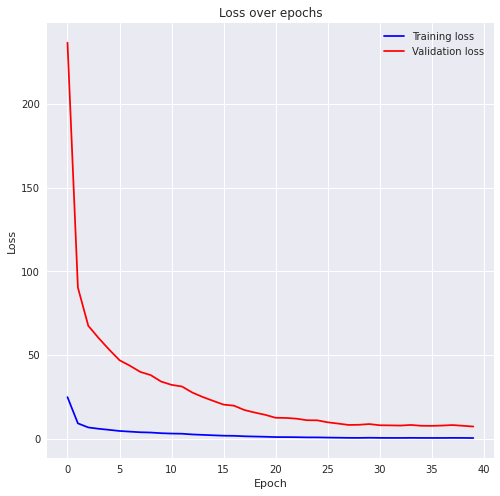

In [8]:
def plot_losses(train_losses:list, valid_losses:list):
    plt.style.use('seaborn')
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)
    fig, ax = plt.subplots(figsize = (8, 8))
    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    plt.style.use('default')
    plt.show()
    
plot_losses(train_losses, val_losses)

(array([3791.,  516.,  285.,  214., 1618., 5962.,  229.,  306.,  412.,
        1936.]),
 array([-1.00000000e+00, -8.00003052e-01, -6.00006104e-01, -4.00009155e-01,
        -2.00012207e-01, -1.52587891e-05,  1.99981689e-01,  3.99978638e-01,
         5.99975586e-01,  7.99972534e-01,  9.99969482e-01]),
 <BarContainer object of 10 artists>)

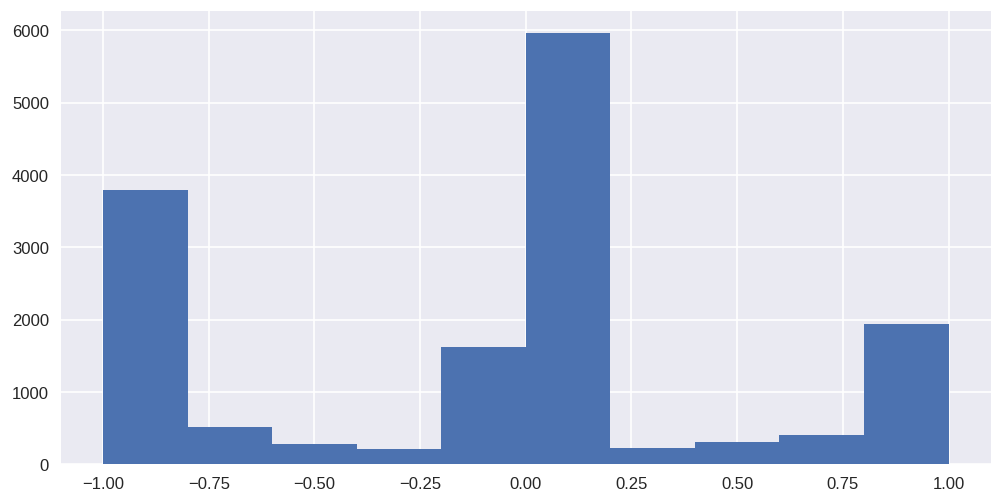

In [22]:
steering_data = [x[0] for x in targets_orig]
figure(figsize=(10, 5), dpi=120)
plt.style.use('seaborn')
plt.hist(steering_data)

In [ ]:
# Unbalanced data between left and right steering, maybe need to collect better data.